In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'
import pickle
import numpy as np
import json
from pprint import pprint
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
postgre_manager = DBManager(db_params)

from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, make_zscore_df, create_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy, create_pair_trades_df

In [2]:
def create_spread_hist_df(token_1, token_2, min_order, method, curr_order, hours_back):
    curr_order = orders.filter(
        (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2)
    ).tail(1)

    tf = curr_order['tf'][0]
    wind = curr_order['wind'][0]
    train_len = int(tf[0]) * wind * 2

    ct = curr_order['ct'][0]
    st_time = datetime.strptime(ct, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
    valid_time = st_time - timedelta(hours = hours_back)
    start_time = valid_time - timedelta(hours = train_len)
    thresh_in = curr_order['thresh_in'][0]
    thresh_out = curr_order['thresh_out'][0]
    side = curr_order['side'][0]

    df_1 = postgre_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time)
    df_2 = postgre_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time)

    df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time,
                             )

    if tf == '1h':
        agg_df = make_trunc_df(df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')[:-1]
    elif tf == '4h':
        agg_df = make_trunc_df(df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')[:-1]
    else:
        raise NotImplementedError('Введите верный таймфрейм ("1h", "4h")')

    df_sec = make_trunc_df(df, timeframe='1s', token_1=token_1, token_2=token_2, start_date=valid_time, method='last', return_bid_ask=True)

    result_df = create_zscore_df(token_1, token_2, df_sec, agg_df, np.array((wind,)), method, min_order)

    result_df = result_df.select('time', token_1, token_2, f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'beta_{wind}', f'z_score_{wind}').rename(
        {f'beta_{wind}': 'beta', f'z_score_{wind}': 'z_score'}
                    )
    return result_df

In [3]:
def plot_graphs(current_pairs, thr_in, thr_out):
    for row in current_pairs.iter_rows(named=True):
        token_1 = row['token_1']
        token_2 = row['token_2']
        side = row['side_1']
        t1_name = token_1[:-5]
        t2_name = token_2[:-5]
        open_time = row['created_at']

        tf = '4h'
        wind = 24

        start_ts = int(datetime.timestamp(open_time))
        end_ts = int(datetime.timestamp(datetime.now()))
        hist = postgre_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)

        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)

        fig, ax1 = plt.subplots(figsize=(14, 3))

        # График z_score
        ax1.plot(hist.select('time'), hist.select(f'z_score'), color='blue', label='z_score', ls='-', lw=0.75)
        ax1.set_title(f'{token_1[:-5]} - {token_2[:-5]} ({side}; tf: {tf}; wind: {wind}). z_score: {curr_zscore}; profit: {curr_profit}')

        ax1.set_ylabel('z_score')

        if side == 'long':
            ax1.axhline(-thr_in, c='g', linestyle='dotted')
            ax1.axhline(thr_out, c='r', linestyle='dotted')
        else:
            ax1.axhline(thr_in, c='g', linestyle='dotted')
            ax1.axhline(-thr_out, c='r', linestyle='dotted')

        # График профита
        ax2 = ax1.twinx()
        ax2.plot(hist.select('time'), hist.select('profit'), color='green', label='profit', lw=2.0)
        ax2.set_ylabel('profit')
        ax2.grid()
        plt.tight_layout()
        fig.legend(loc='upper right', bbox_to_anchor=(0.135, 0.9))
        plt.show()

In [4]:
current_pairs = postgre_manager.get_table('pairs', df_type='polars')

for row in current_pairs.iter_rows(named=True):
    token_1 = row['token_1']
    token_2 = row['token_2']
    side = row['side_1']
    t1_name = token_1[:-5]
    t2_name = token_2[:-5]
    open_time = row['created_at']

    tf = '4h'
    wind = 24

    end_ts = int(datetime.timestamp(datetime.now()))
    start_ts = end_ts - 60

    hist = postgre_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)

    curr_zscore = round(hist[-1]['z_score'][0], 2)
    curr_profit = round(hist[-1]['profit'][0], 2)

    print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} ({side:>5}, tf: {tf}; wind: {wind:>2}): z_score: {curr_zscore:5}; profit: {curr_profit:5}')

   CHZ - KAS    (short, tf: 4h; wind: 24): z_score:  2.18; profit: -6.89
   DOT - NEAR   (short, tf: 4h; wind: 24): z_score:  2.67; profit: -7.46
  CELO - IMX    (short, tf: 4h; wind: 24): z_score:  2.19; profit: -2.94
  ARKM - MANTA  (short, tf: 4h; wind: 24): z_score:  0.48; profit:  0.93


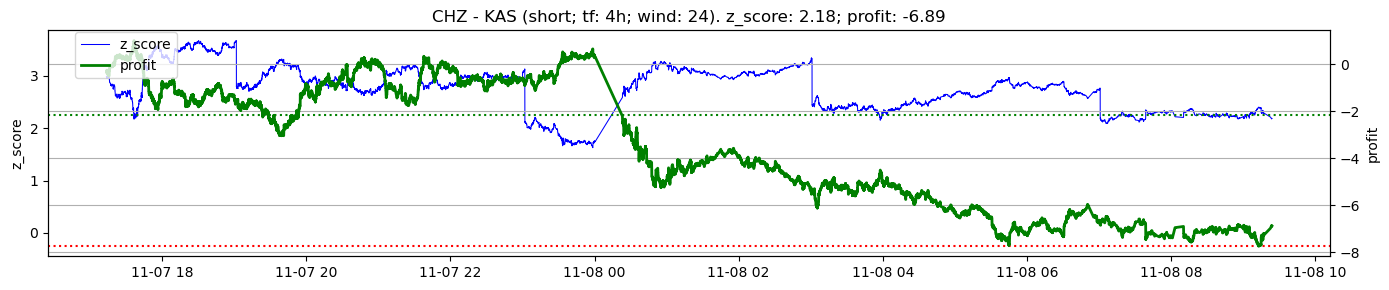

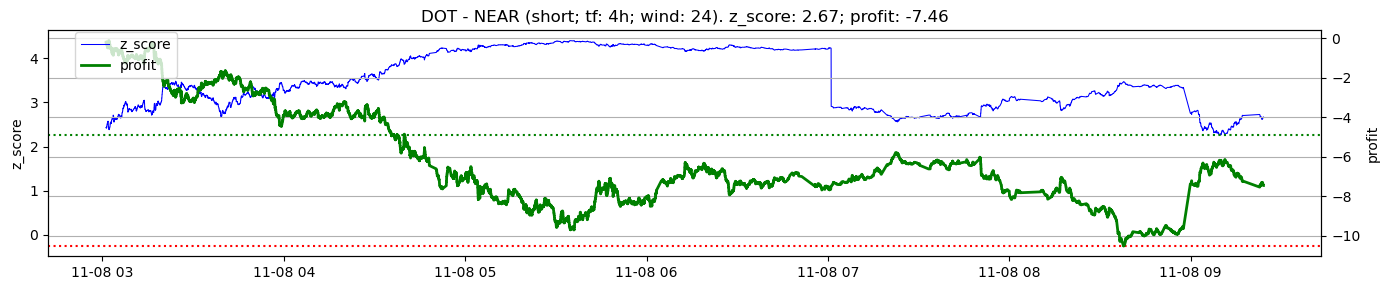

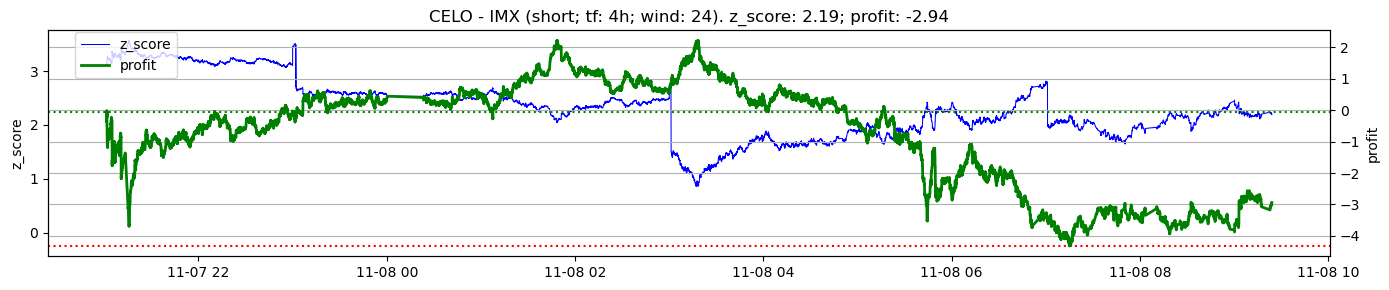

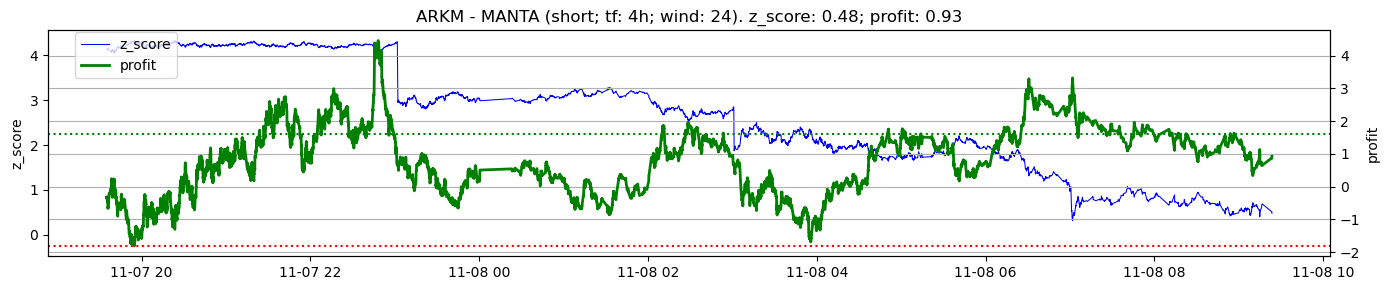

In [5]:
plot_graphs(current_pairs, thr_in=2.25, thr_out=0.25)

In [ ]:
# Разобрать
# RENDER - XRP

In [ ]:
pairs = postgre_manager.get_table('pairs', df_type='polars')
pairs.select('token_1', 'token_2', 'created_at', 'side_1', 'qty_1', 'qty_2', 'usdt_1', 'usdt_2',
            'rpnl_1', 'rpnl_2', 'upnl_1', 'upnl_2', 'profit_1', 'profit_2', 'profit', 'status')

token_1,token_2,created_at,side_1,qty_1,qty_2,usdt_1,usdt_2,rpnl_1,rpnl_2,upnl_1,upnl_2,profit_1,profit_2,profit,status
str,str,"datetime[μs, Europe/Moscow]",str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""ARKM_USDT""","""MANTA_USDT""",2025-11-07 19:34:53 MSK,"""short""",298.0,906.1,49.7958,49.944232,-0.044312,-0.065633,-5.8408,7.547813,-5.885112,7.48218,1.597067,"""active"""
"""CHZ_USDT""","""KAS_USDT""",2025-11-07 17:13:33 MSK,"""short""",3190.0,2010.0,49.93945,49.7475,-0.050188,-0.070376,-10.8141,4.9245,-10.864288,4.854124,-6.010164,"""active"""
"""DOT_USDT""","""NEAR_USDT""",2025-11-08 03:01:08 MSK,"""short""",30.6,35.7,49.8321,49.92645,-0.054834,-0.054919,-6.20568,-2.3919,-6.260514,-2.446819,-8.707333,"""active"""
"""CELO_USDT""","""IMX_USDT""",2025-11-07 21:01:17 MSK,"""short""",401.1,228.4,49.93695,49.93966,-0.044967,-0.065028,-2.56704,2.5124,-2.612007,2.447372,-0.164635,"""active"""
"""ONDO_USDT""","""POL_USDT""",2025-11-08 05:20:28 MSK,"""long""",147.0,537.0,49.64925,49.8873,-0.05459,-0.054876,0.2205,-0.2685,0.16591,-0.323376,-0.157466,"""active"""


In [6]:
trading_history = postgre_manager.get_table('trading_history', df_type='polars')
trading_history.tail(3)

token_1,token_2,open_time,close_time,side_1,side_2,qty_1,qty_2,open_price_1,open_price_2,close_price_1,close_price_2,fee_1,fee_2,leverage,pnl_1,pnl_2,profit
str,str,"datetime[μs, Europe/Moscow]","datetime[μs, Europe/Moscow]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LDO""","""SAND""",2025-11-07 00:49:13 MSK,2025-11-07 19:34:53 MSK,"""long""","""short""",135.8,553.0,0.7353,0.1807,0.8061,0.1998,-0.113001,-0.095834,2.0,9.501639,-10.658134,-1.156495
"""GRT""","""SEI""",2025-11-07 08:04:35 MSK,2025-11-08 03:01:08 MSK,"""short""","""long""",1723.1,606.0,0.05798,0.1646,0.07022,0.1809,-0.109009,-0.132181,2.0,-21.199753,9.745619,-11.454134
"""CRV""","""SUI""",2025-11-07 07:24:35 MSK,2025-11-08 05:20:28 MSK,"""short""","""long""",231.4,40.0,0.4316,1.9991,0.4868,2.1796,-0.092705,-0.115184,2.0,-12.865985,7.104816,-5.761169


In [7]:
trading_history['profit'].sum()

7.6488097999999916

In [ ]:
# postgre_manager.clear_table('pairs')

In [22]:
# postgre_manager.delete_pair_order(token_1='ONDO_USDT', token_2='POL_USDT')